Notebook to implement experiments from [Hertrich & al. 2024]

In [44]:
#IMPORT
import numpy as np 
import torch
import math
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import pandas as pd
import seaborn as sns
import time

Let's $\mu = \frac{1}{N}\sum_{i=1}^N\delta_{x_i} $ and $\nu=\frac{1}{M}\sum_{j=1}^N\delta_{y_j}$, we want : 

$$F_d(x \mid y) = -\frac{1}{2N^2} \sum_{i,j=1}^N \|x_i - x_j\| + \frac{1}{MN} \sum_{i=1}^N \sum_{j=1}^M \|x_i - y_j\| = \mathrm{MMD}_k^2(\mu, \nu) + \text{const}_y $$

To compute the classical GF we want the gradient. To evaluate the gradient of \( F_d \), we use Theorem Theorem 1 to rewrite:

$$
F_d(x \mid y) = c_{d,1} \, \mathbb{E}_{\xi \sim \mathcal{U}(\mathbb{S}^{d-1})} \left[ F_1\left( \langle \xi, x_1 \rangle, \dots, \langle \xi, x_N \rangle \mid \langle \xi, y_1 \rangle, \dots, \langle \xi, y_M \rangle \right) \right]
$$
Hence with the chain rule we get: 
$$
\nabla_{x_i} F_d(x \mid y) = c_{d,1} \, \mathbb{E}_{\xi \sim \mathcal{U}(\mathbb{S}^{d-1})} \left[ \partial_i F_1\left( \langle \xi, x_1 \rangle, \dots, \langle \xi, x_N \rangle \mid \langle \xi, y_1 \rangle, \dots, \langle \xi, y_M \rangle \right) \xi \right]
$$


We just need the gradient of $ F_1 $ to compute the gradient of $ F_d $.

$$F_1(x \mid y) = E(x) + V(x \mid y)
= -\frac{1}{2N^2} \sum_{i,j=1}^N |x_i - x_j| + \frac{1}{NM} \sum_{i=1}^N \sum_{j=1}^M |x_i - y_j|.$$

#### Grad in 1d

In [2]:
def grad_MMD_1D(x,y):
    """
    Compute the gradient of F_1 thanks to the algorithms of Theorem 3. 
    Take x,y of the size (P,N), (P,M) with P the number of projections
    """

    N = x.shape[1]
    M = y.shape[1]

    P = x.shape[0] #number of projections that we've got (i.e the number of times we have to compute 1D gradient)

    #Compute Grad of repulsion term E(x)
    _, sigma = torch.sort(x,dim=1) #argsort on each proj (P,N)

    sigma_inv = torch.empty_like(sigma)
    arange_N = torch.arange(N, device=x.device).expand(P, N)
    sigma_inv.scatter_(1, sigma, arange_N) #For each proj: in each pos sigma you put arrange_N

    repulsion = (N + 1 - 2*sigma_inv) / N**2

    #Compute Grade of attraction term V(x|y)
    _, sigma = torch.sort(torch.cat((x,y),1))
    h = torch.where(sigma>=N,1.,0.) #we put 1 at sigma(N+j) j=1,...,M
    h = (2*torch.cumsum(h,-1)-M) / (N*M)
    _,inverted_inds=torch.sort(sigma)
    inverted_inds=inverted_inds[:,:N]+torch.arange(P,device=x.device).unsqueeze(1)*(N+M)
    inverted_inds=torch.flatten(inverted_inds)
    h=h.flatten()
    attraction=h[inverted_inds].reshape(P,-1)


    grad = repulsion + attraction

    return grad

In [3]:
#Code of FabianAltekrueger

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


def MMD_derivative_1d(x,y,only_potential=False):
    '''
    compute the derivate of MMD in 1D
    '''
    N=x.shape[1]
    P=1
    if len(x.shape)>1:
        P=x.shape[0]
    # potential energy
    if y is None:
        grad=torch.zeros(P,N,device=device)
    else:
        M=y.shape[1]
        _,inds=torch.sort(torch.cat((x,y),1))
        grad=torch.where(inds>=N,1.,0.)
        grad=(2*torch.cumsum(grad,-1)-M) / (N*M)
        _,inverted_inds=torch.sort(inds)
        inverted_inds=inverted_inds[:,:N]+torch.arange(P,device=device).unsqueeze(1)*(N+M)
        inverted_inds=torch.flatten(inverted_inds)
        grad=grad.flatten()
        grad=grad[inverted_inds].reshape(P,-1)


    if not only_potential:
        _,inds_x=torch.sort(x)
        inds_x=inds_x+torch.arange(P,device=device).unsqueeze(1)*N
        inds_x=torch.flatten(inds_x)
        # interaction energy
        #interaction=2*torch.arange(N,device=device)-N-1
        interaction=2*torch.arange(N,device=device)-N+1
        interaction=(1/(N**2)) * interaction
        interaction=interaction.tile(P,1)
        grad=grad.flatten()
        grad[inds_x]=grad[inds_x]-interaction.flatten()
        grad=grad.reshape(P,-1)

    return grad

#### Problem in their implementation 

In [4]:
N = 10
M = 20
P = 1
x = torch.randn((P,N))
y = torch.zeros((P,M))
MMD_derivative_1d(x,y)-grad_MMD_1D(x,y),torch.norm(MMD_derivative_1d(x,y)-grad_MMD_1D(x,y))

(tensor([[-0.0200, -0.0200, -0.0200, -0.0200, -0.0200, -0.0200, -0.0200, -0.0200,
          -0.0200, -0.0200]]),
 tensor(0.0632))

In [5]:
(2/N**2) 

0.02

#### Grad 

We use Monte Carlo to approximate the gradient: 

$$ \widetilde{\nabla}_{P, x_i} F_d(x \mid y) = \frac{c_{d,1}}{P} \sum_{p=1}^P \partial_i F_1\left( \langle \xi_p, x_1 \rangle, \dots, \langle \xi_p, x_N \rangle \mid \langle \xi_p, y_1 \rangle, \dots, \langle \xi_p, y_M \rangle \right) \xi_p$$

In [6]:
def compute_cste(d): 
    '''
    compute the scaling factor of sliced MMD
    '''
    k = (d-1)//2
    fac = 1.
    if (d-1)%2==0:
        for j in range(1,k+1):
            fac=2*fac*j/(2*j-1)
    else:
        for j in range(1,k+1):
            fac=fac*(2*j+1)/(2*j)
        fac=fac*math.pi/2
    return fac

In [7]:
def gradient_MMD_approx(x,y,num_proj=None):
    """
    Compute the approximate gradient of the MMD using Sliced MMD
    take x,y of the size (N,d), (M,d)
    """

    d = x.shape[-1]

    if num_proj == None:
        num_proj = d #If not specified we take P = d

    p = torch.randn((num_proj,d),device=device)
    p = p/torch.sqrt(torch.sum(p**2,-1,keepdim=True)) #size (P,d)

    x_proj = p @ x.T 
    y_proj = p @ y.T

    grad_1d = grad_MMD_1D(x_proj,y_proj) # size (P,N)

    grad = (grad_1d.T @ p) / num_proj # size (N,d)

    return grad


In [8]:
def riesz_kernel(x,y):
    """
    Compute riesz kernel for x,y of the size (N,d) and (M,d)
    """
    x_norm = (x ** 2).sum(dim=1).unsqueeze(1)  # (N, 1)
    y_norm = (y ** 2).sum(dim=1).unsqueeze(0)  # (1, M)
    dist_sq = x_norm + y_norm - 2.0 * x @ y.T
    dist_sq = torch.clamp(dist_sq, min=0)
    riesz = - torch.sqrt(dist_sq) # (N,M)

    return riesz


def MMD(x,y,kernel=riesz_kernel):
    """
    Compute the approximate MMD^2 distance with riesz kernel
    take x,y of the size (N,d), (M,d)
    """

    kxx = kernel(x,x)
    kyy = kernel(y,y)
    kxy = kernel(x,y)

    mmd = kxx.mean() + kyy.mean() - 2 * kxy.mean()
    return mmd

In [9]:
def GF_MMD(x0,y,step_size,n_steps,log_every=100,momentum=True,m=0.7,num_proj=None,patience=-1):
    """
    Compute the approximate gradient flow of the MMD using Sliced MMD
    take x,y of the size (N,d), (M,d)
    """
    x = x0
    v = torch.zeros_like(x)
    N = x0.shape[0]
    x_evolv = []
    norm_grad_evolv = {0:torch.norm(torch.mean(gradient_MMD_approx(x,y,num_proj),dim=0))}
    best_mmd = MMD(x,y)
    patience_count = 0
    mmd_evolv = {0:best_mmd}

    for iter in range(1,n_steps+1):
        grad = gradient_MMD_approx(x,y,num_proj)
        if momentum:
            v = grad + m * v
            x = x - step_size * N * v 
        else:
            x = x - step_size * N * grad
        
        x_evolv.append(x)
        if iter % log_every == 0 :
            mmd = MMD(x,y)
            norm_grad =  torch.norm(torch.mean(grad,dim=0)) #We do the mean on all gradients and calculate the norm
            print(f"Iter: {iter} | MMD value: {mmd} | Mean Grad Norm: {norm_grad}")
            mmd_evolv[iter] = mmd
            norm_grad_evolv[iter] = norm_grad

            if patience > 0:
                if best_mmd > mmd:
                    best_mmd = mmd
                    patience_count = 0
                else: 
                    patience_count += 1
                
                if patience_count > patience:
                    step_size = max(step_size/10,1e-5)
                    print(f"Patience attained, we divided the lr, lr={step_size}")
                    patience_count = 0 
                


    return x_evolv,mmd_evolv,norm_grad_evolv    


In [10]:
def naivegrad_MMD(x, y):
    """
    Compute the gradient of the MMD in a naive way.
    with x: (N, d)  y: (M, d)
    """
    N, d = x.shape
    M = y.shape[0]

    diff_xx = x.unsqueeze(1) - x.unsqueeze(0)  # (N, N, d)
    dist_xx = torch.norm(diff_xx, dim=2, keepdim=True)  # (N, N, 1)
    normed_diff_xx = diff_xx / dist_xx  # (N, N, d)

    # Masque pour ignorer les termes diagonaux (x_i - x_i)
    mask = ~torch.eye(N, dtype=torch.bool, device=x.device)
    repulsion = -normed_diff_xx[mask].view(N, N - 1, d).sum(dim=1) / (N ** 2)

    
    diff_xy = x.unsqueeze(1) - y.unsqueeze(0)  # (N, M, d)
    dist_xy = torch.norm(diff_xy, dim=2, keepdim=True) #(N, M, 1)
    normed_diff_xy = diff_xy / dist_xy # (N, M, d)
    attraction = normed_diff_xy.sum(dim=1) / (M * N) # (N,d)

    return repulsion + attraction


In [334]:
N = 1000
M = 1000
d = 100
x = torch.rand((N,d)) 
y = torch.rand((M,d))

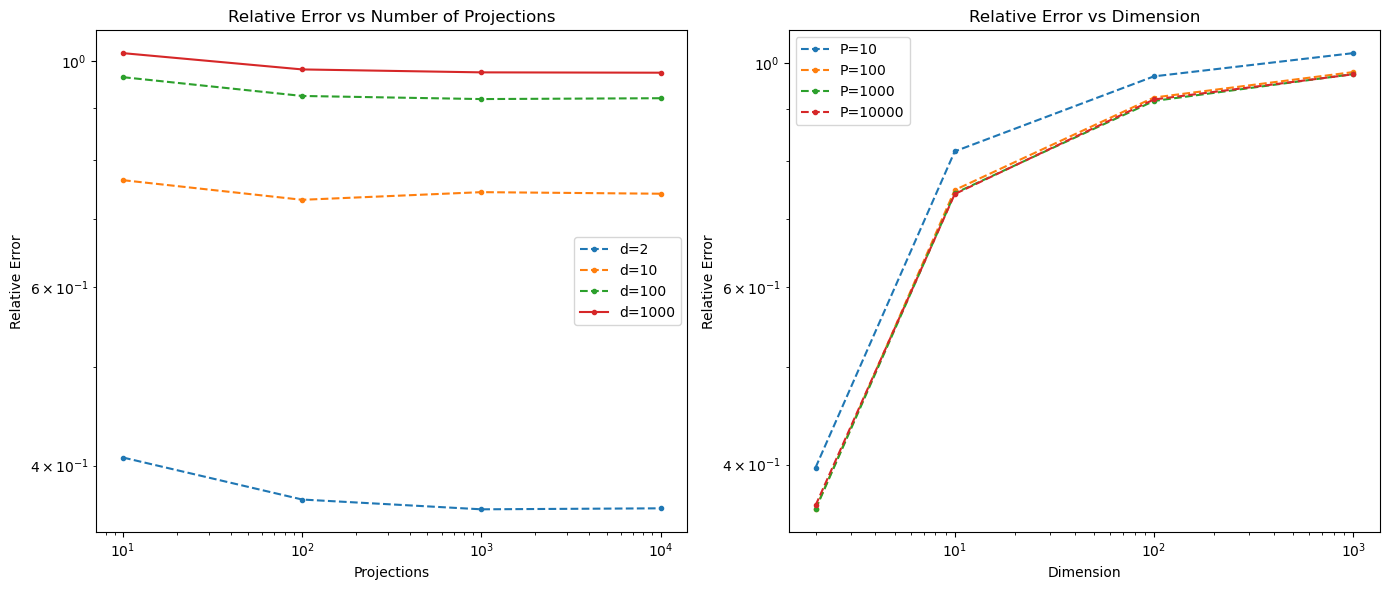

In [14]:
# Given fixed parameters
N = 1000
M = 1000
num_trials = 3 # average over several runs
std = 0.01

# Values to test
P_list = [10, 100, 1000, 10000]
d_list = [2, 10, 100, 1000]

# Containers for errors
error_vs_P = {d: [] for d in d_list}
error_vs_d = {P: [] for P in P_list}


# Compute error as a function of P (left plot)
for d in d_list:
    for P in P_list:
        rel_errors = []
        for _ in range(num_trials):
            mus_x = 2 * torch.rand((2, d)) - 1
            mus_y = 2 * torch.rand((10, d)) - 1
            x = torch.cat([mu + std * torch.randn((N // 2, d)) for mu in mus_x])
            y = torch.cat([mu + std * torch.randn((M // 10, d)) for mu in mus_y])

            grad_true = naivegrad_MMD(x, y)
            grad_approx = gradient_MMD_approx(x, y, num_proj=P)

            rel_error = torch.norm(grad_true - grad_approx) / torch.norm(grad_true)
            rel_errors.append(rel_error.item())
        error_vs_P[d].append(np.mean(rel_errors))

# Compute error as a function of d (right plot)
for P in P_list:
    for d in d_list:
        rel_errors = []
        for _ in range(num_trials):
            mus_x = 2 * torch.rand((2, d)) - 1
            mus_y = 2 * torch.rand((10, d)) - 1
            x = torch.cat([mu + std * torch.randn((N // 2, d)) for mu in mus_x])
            y = torch.cat([mu + std * torch.randn((M // 10, d)) for mu in mus_y])

            grad_true = naivegrad_MMD(x, y)
            grad_approx = gradient_MMD_approx(x, y, num_proj=P)

            rel_error = torch.norm(grad_true - grad_approx) / torch.norm(grad_true)
            rel_errors.append(rel_error.item())
        error_vs_d[P].append(np.mean(rel_errors))

# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Left: Error vs P
for d, errors in error_vs_P.items():
    ax1.plot(P_list, errors, label=f'd={d}', linestyle='--' if d < 1000 else '-', marker='.')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel("Projections")
ax1.set_ylabel("Relative Error")
ax1.set_title("Relative Error vs Number of Projections")
ax1.legend()

# Right: Error vs d
for P, errors in error_vs_d.items():
    ax2.plot(d_list, errors, label=f'P={P}', linestyle='--', marker='.')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlabel("Dimension")
ax2.set_ylabel("Relative Error")
ax2.set_title("Relative Error vs Dimension")
ax2.legend()

plt.tight_layout()
plt.show()

### Example of GF with toy data

In [15]:
#Code from clementinechazal

def _generate_data():
    N, r, _delta = 50, 0.3, 0.5
    
    X = np.c_[r * np.cos(np.linspace(0, 2 * np.pi, N + 1)), r * np.sin(np.linspace(0, 2 * np.pi, N + 1))][:-1]  # noqa
    for i in [1, 2]:
        X = np.r_[X, X[:N, :]-i*np.array([0, (2 + _delta) * r])]

    rs = np.random.RandomState(42)
    Y = rs.randn(N*(2+1), 2) / 100 - np.array([r/np.sqrt(2), r/np.sqrt(2)])
    Y = rs.randn(N*(2+1), 2) / 100 - np.array([0, r])

    Y = torch.from_numpy(Y).float()
    X = torch.from_numpy(X).float()
    Y.requires_grad = False
    return X, Y

Y,X = _generate_data()

[]

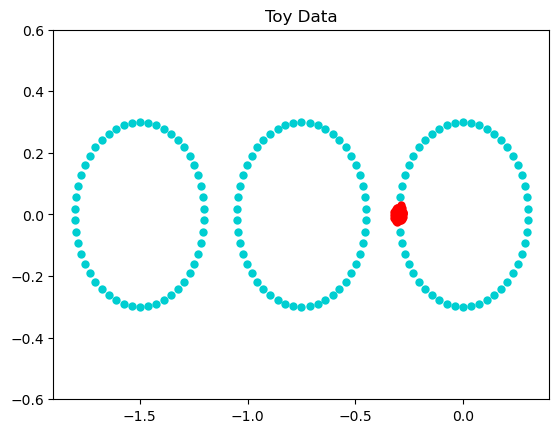

In [16]:
plt.title('Toy Data')
plt.xlim([-1.9, 0.4])
plt.ylim([-0.6, 0.6])
plt.scatter(Y[:, 1], Y[:, 0],color = "darkturquoise",linewidths=1e-5)
plt.scatter(X[:, 1],X[:, 0],color = "red",linewidths=1e-5)
plt.plot()


In [17]:
x_evolv,mmd_evolv,grad_norm_evolv = GF_MMD(X,Y,0.001,100000)

Iter: 100 | MMD value: 0.38557636737823486 | Mean Grad Norm: 0.0020789243280887604
Iter: 200 | MMD value: 0.27403712272644043 | Mean Grad Norm: 0.0017471438040956855
Iter: 300 | MMD value: 0.1954895257949829 | Mean Grad Norm: 0.0006289510638453066
Iter: 400 | MMD value: 0.14296412467956543 | Mean Grad Norm: 0.0003460017032921314
Iter: 500 | MMD value: 0.10644364356994629 | Mean Grad Norm: 0.0007052288274280727
Iter: 600 | MMD value: 0.07792019844055176 | Mean Grad Norm: 0.0005010329186916351
Iter: 700 | MMD value: 0.05800354480743408 | Mean Grad Norm: 0.0004410413675941527
Iter: 800 | MMD value: 0.04346668720245361 | Mean Grad Norm: 0.00028382460004650056
Iter: 900 | MMD value: 0.03357887268066406 | Mean Grad Norm: 6.088311783969402e-05
Iter: 1000 | MMD value: 0.026677608489990234 | Mean Grad Norm: 0.00029769266257062554
Iter: 1100 | MMD value: 0.02061772346496582 | Mean Grad Norm: 0.0002244629431515932
Iter: 1200 | MMD value: 0.01634538173675537 | Mean Grad Norm: 0.0002297619212185964

Axes(0.125,0.11;0.227941x0.77)


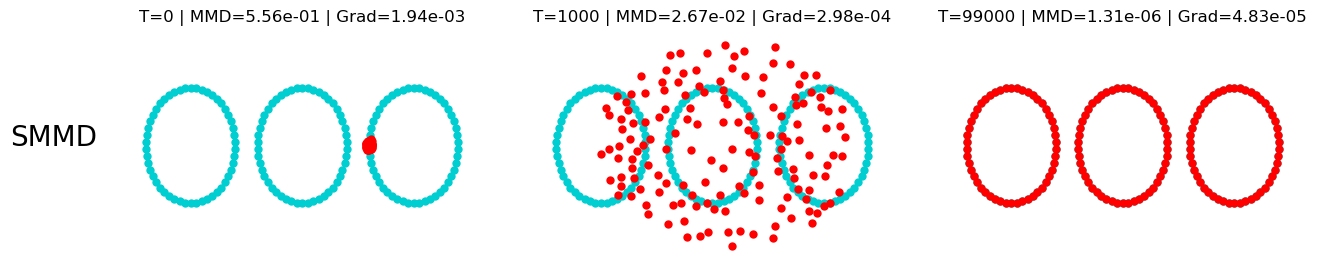

In [18]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 3))

iters = [0, 1000, 99000]

print(axs[0])

axs[0].text(-0.1, 0.5, "SMMD", size=20, transform=axs[0].transAxes, horizontalalignment='right')
for it,ax in zip(iters, axs):
    ax.set_title(f'T={it} | MMD={mmd_evolv[it]:.2e} | Grad={grad_norm_evolv[it]:.2e}')
    ax.set_xlim([-1.9, 0.4])
    ax.set_ylim([-0.6, 0.6])
    ax.scatter(Y[:, 1], Y[:, 0],color = "darkturquoise",linewidths=1e-5)
    ax.scatter(x_evolv[it][:, 1],x_evolv[it][:, 0],color = "red",linewidths=1e-5)
    ax.axis('off')

### Example of GF with MNIST

In [19]:
transform = transforms.ToTensor()
mnist_train = datasets.MNIST(root='../data', train=True, download=False, transform=transform)
train_loader = DataLoader(mnist_train, batch_size=64, shuffle=True)

In [20]:
Y = next(iter(train_loader))[0].reshape(64,-1)
labels = next(iter(train_loader))[1]
X = torch.rand((64,28**2))

In [21]:
x_evolv, mmd_evolv, grad_norm_evolv = GF_MMD(X,Y,1,80000,patience=10)

Iter: 100 | MMD value: 3.2277450561523438 | Mean Grad Norm: 0.00027968111680820584
Iter: 200 | MMD value: 0.9557209014892578 | Mean Grad Norm: 0.00013407427468337119
Iter: 300 | MMD value: 0.38561058044433594 | Mean Grad Norm: 7.166455179685727e-05
Iter: 400 | MMD value: 0.25205421447753906 | Mean Grad Norm: 3.503135303617455e-05
Iter: 500 | MMD value: 0.21831512451171875 | Mean Grad Norm: 2.702339224924799e-05
Iter: 600 | MMD value: 0.20810699462890625 | Mean Grad Norm: 2.0894200133625418e-05
Iter: 700 | MMD value: 0.20444679260253906 | Mean Grad Norm: 2.144081190635916e-05
Iter: 800 | MMD value: 0.2028636932373047 | Mean Grad Norm: 2.1699454009649344e-05
Iter: 900 | MMD value: 0.20209503173828125 | Mean Grad Norm: 2.338760532438755e-05
Iter: 1000 | MMD value: 0.20157241821289062 | Mean Grad Norm: 2.220651731477119e-05
Iter: 1100 | MMD value: 0.201171875 | Mean Grad Norm: 2.1351288523874246e-05
Iter: 1200 | MMD value: 0.20081710815429688 | Mean Grad Norm: 2.245679934276268e-05
Iter: 1

In [57]:
x_evolv, mmd_evolv, grad_norm_evolv = GF_MMD(X,Y,1,10_000,patience=10)

Iter: 100 | MMD value: 0.18463516235351562 | Mean Grad Norm: 3.387858214409789e-06
Iter: 200 | MMD value: 0.1454944610595703 | Mean Grad Norm: 1.4362180991156492e-06
Iter: 300 | MMD value: 0.12501144409179688 | Mean Grad Norm: 6.417790245905053e-07
Iter: 400 | MMD value: 0.11250114440917969 | Mean Grad Norm: 4.3597869989753235e-06
Iter: 500 | MMD value: 0.10294532775878906 | Mean Grad Norm: 6.18030526311486e-06
Iter: 600 | MMD value: 0.09249687194824219 | Mean Grad Norm: 7.187467417679727e-06
Iter: 700 | MMD value: 0.0773468017578125 | Mean Grad Norm: 9.48301749303937e-06
Iter: 800 | MMD value: 0.06202888488769531 | Mean Grad Norm: 2.0080853573745117e-05
Iter: 900 | MMD value: 0.05131721496582031 | Mean Grad Norm: 1.6166624845936894e-05
Iter: 1000 | MMD value: 0.04081916809082031 | Mean Grad Norm: 1.8135753634851426e-05
Iter: 1100 | MMD value: 0.030649185180664062 | Mean Grad Norm: 1.64098364621168e-05
Iter: 1200 | MMD value: 0.022739410400390625 | Mean Grad Norm: 1.749308103171643e-05

In [39]:
(Y-x_evolv[-1][0]).shape
torch.norm(Y - x_evolv[-1][0], dim=1).shape

torch.Size([64])

In [52]:
x_evolv[-1].shape

torch.Size([64, 784])

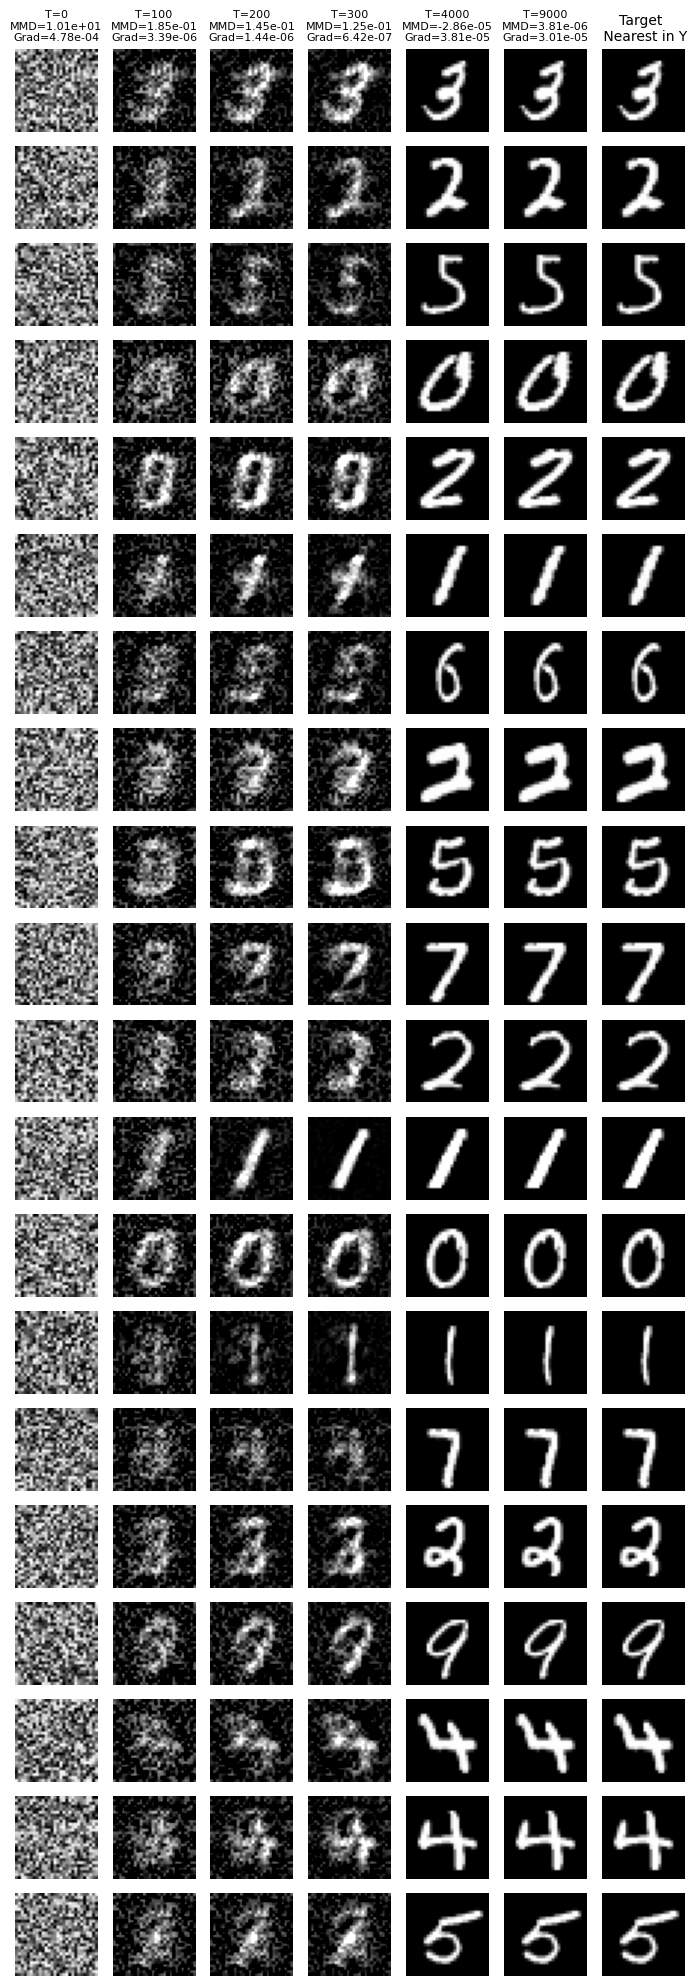

In [60]:
#iters = [0,1000,2000,5000,10000,15000,20000,79900]  
iters = [0,100,200,300,4000,9000]
n_rows = 20
n_cols = len(iters) + 1

fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols, n_rows))




for i in range(n_rows):
    for j, it in enumerate(iters):
        img = x_evolv[it][i]
        img = img.reshape((28,28))
        axs[i, j].imshow(img.cpu(), cmap='gray', vmin=0, vmax=1)
        axs[i, j].axis('off')

    x_final = x_evolv[-1][i]

    for _ in range(64):
        dists = torch.norm(Y - x_final, dim=1)
        j = torch.argmin(dists)
        true_target = Y[j]

    # Dernière colonne : vraie image MNIST
    real_img = true_target.reshape((28,28))  
    axs[i, -1].imshow(real_img.cpu(), cmap='gray', vmin=0, vmax=1)
    axs[i, -1].axis('off')


for j, it in enumerate(iters):
    mmd = mmd_evolv[it]
    grad = grad_norm_evolv[it]
    axs[0, j].set_title(f"T={it}\nMMD={mmd:.2e}\nGrad={grad:.2e}", fontsize=8)


axs[0, -1].set_title("Target \n Nearest in Y", fontsize=10)

#espacement
plt.subplots_adjust(wspace=0.3, hspace=0.1)
plt.tight_layout()
plt.show()

In [46]:
def GF_MMD_naive(x0,y,step_size,n_steps,log_every=100,momentum=True,m=0.7,num_proj=None,patience=-1):
    """
    Compute the approximate gradient flow of the MMD using Sliced MMD
    take x,y of the size (N,d), (M,d)
    """
    x = x0
    v = torch.zeros_like(x)
    N = x0.shape[0]
    x_evolv = []
    norm_grad_evolv = {0:torch.norm(torch.mean(gradient_MMD_approx(x,y,num_proj),dim=0))}
    best_mmd = MMD(x,y)
    patience_count = 0
    mmd_evolv = {0:best_mmd}


    for iter in range(1,n_steps+1):
        grad = naivegrad_MMD(x,y)
        if momentum:
            v = grad + m * v
            x = x - step_size * N * v 
        else:
            x = x - step_size * N * grad
        
        x_evolv.append(x)
        if iter % log_every == 0 :
            mmd = MMD(x,y)
            norm_grad =  torch.norm(torch.mean(grad,dim=0)) #We do the mean on all gradients and calculate the norm
            print(f"Iter: {iter} | MMD value: {mmd} | Mean Grad Norm: {norm_grad}")
            mmd_evolv[iter] = mmd
            norm_grad_evolv[iter] = norm_grad

            if patience > 0:
                if best_mmd > mmd:
                    best_mmd = mmd
                    patience_count = 0
                else: 
                    patience_count += 1
                
                if patience_count > patience:
                    step_size = max(step_size/10,1e-5)
                    print(f"Patience attained, we divided the lr, lr={step_size}")
                    patience_count = 0 
                


    return x_evolv,mmd_evolv,norm_grad_evolv 

start = time.time()
GF_MMD(X,Y,1,300)
end = time.time()

start_naive = time.time()
GF_MMD_naive(X,Y,1,300)
end_naive = time.time()
print(f"Sliced version took: {end-start}s")
print(f"Naive version took: {end_naive-start_naive}s")


Iter: 100 | MMD value: 3.2288131713867188 | Mean Grad Norm: 0.0003306677099317312
Iter: 200 | MMD value: 0.9426651000976562 | Mean Grad Norm: 0.0001366909418720752
Iter: 300 | MMD value: 0.3821220397949219 | Mean Grad Norm: 6.960223254282027e-05
Iter: 100 | MMD value: 0.18463516235351562 | Mean Grad Norm: 3.387858214409789e-06
Iter: 200 | MMD value: 0.1454944610595703 | Mean Grad Norm: 1.4362180991156492e-06
Iter: 300 | MMD value: 0.12501144409179688 | Mean Grad Norm: 6.417790245905053e-07
Sliced version took: 4.163534164428711s
Naive version took: 0.7259519100189209s


In [192]:
def GF_MMD_naive_grad_evolv(x0,y,step_size,n_steps,log_every=100,momentum=True,m=0.7,num_proj=None,patience=-1):
    """
    Compute the approximate gradient flow of the MMD using Sliced MMD
    take x,y of the size (N,d), (M,d)
    """
    x = x0
    v = torch.zeros_like(x)
    N = x0.shape[0]
    x_evolv = []
    norm_grad_evolv = {0:torch.norm(torch.mean(gradient_MMD_approx(x,y,num_proj),dim=0))}
    best_mmd = MMD(x,y)
    patience_count = 0
    mmd_evolv = {0:best_mmd}
    grad_evolv = []


    for iter in range(1,n_steps+1):
        grad = naivegrad_MMD(x,y)
        grad_evolv.append(grad)
        if momentum:
            v = grad + m * v
            x = x - step_size * N * v 
        else:
            x = x - step_size * N * grad
        
        x_evolv.append(x)
        if iter % log_every == 0 :
            mmd = MMD(x,y)
            norm_grad =  torch.norm(torch.mean(grad,dim=0)) #We do the mean on all gradients and calculate the norm
            print(f"Iter: {iter} | MMD value: {mmd} | Mean Grad Norm: {norm_grad}")
            mmd_evolv[iter] = mmd
            norm_grad_evolv[iter] = norm_grad

            if patience > 0:
                if best_mmd > mmd:
                    best_mmd = mmd
                    patience_count = 0
                else: 
                    patience_count += 1
                
                if patience_count > patience:
                    step_size = max(step_size/10,1e-5)
                    print(f"Patience attained, we divided the lr, lr={step_size}")
                    patience_count = 0 
                


    return x_evolv,mmd_evolv,norm_grad_evolv,grad_evolv

x0 = torch.rand((64,28**2))
x_evolv,mmd_evolv,norm_grad_evolv,grad_evolv = GF_MMD_naive_grad_evolv(x0,Y,0.4,10_000)#,patience=10)

Iter: 100 | MMD value: 0.2006053924560547 | Mean Grad Norm: 8.478490940433403e-07
Iter: 200 | MMD value: 0.19244384765625 | Mean Grad Norm: 2.1978762561047915e-06
Iter: 300 | MMD value: 0.1761150360107422 | Mean Grad Norm: 4.042356522404589e-06
Iter: 400 | MMD value: 0.15849685668945312 | Mean Grad Norm: 3.238043063902296e-06
Iter: 500 | MMD value: 0.14552688598632812 | Mean Grad Norm: 1.5559694475086872e-06
Iter: 600 | MMD value: 0.1358623504638672 | Mean Grad Norm: 8.886723890100257e-07
Iter: 700 | MMD value: 0.128509521484375 | Mean Grad Norm: 6.057073846932326e-07
Iter: 800 | MMD value: 0.12280082702636719 | Mean Grad Norm: 4.7194546937134874e-07
Iter: 900 | MMD value: 0.11812591552734375 | Mean Grad Norm: 3.920732751794276e-07
Iter: 1000 | MMD value: 0.11434364318847656 | Mean Grad Norm: 3.381093733878515e-07
Iter: 1100 | MMD value: 0.11068534851074219 | Mean Grad Norm: 3.335815392802033e-07
Iter: 1200 | MMD value: 0.10683822631835938 | Mean Grad Norm: 3.753712462639669e-06
Iter: 

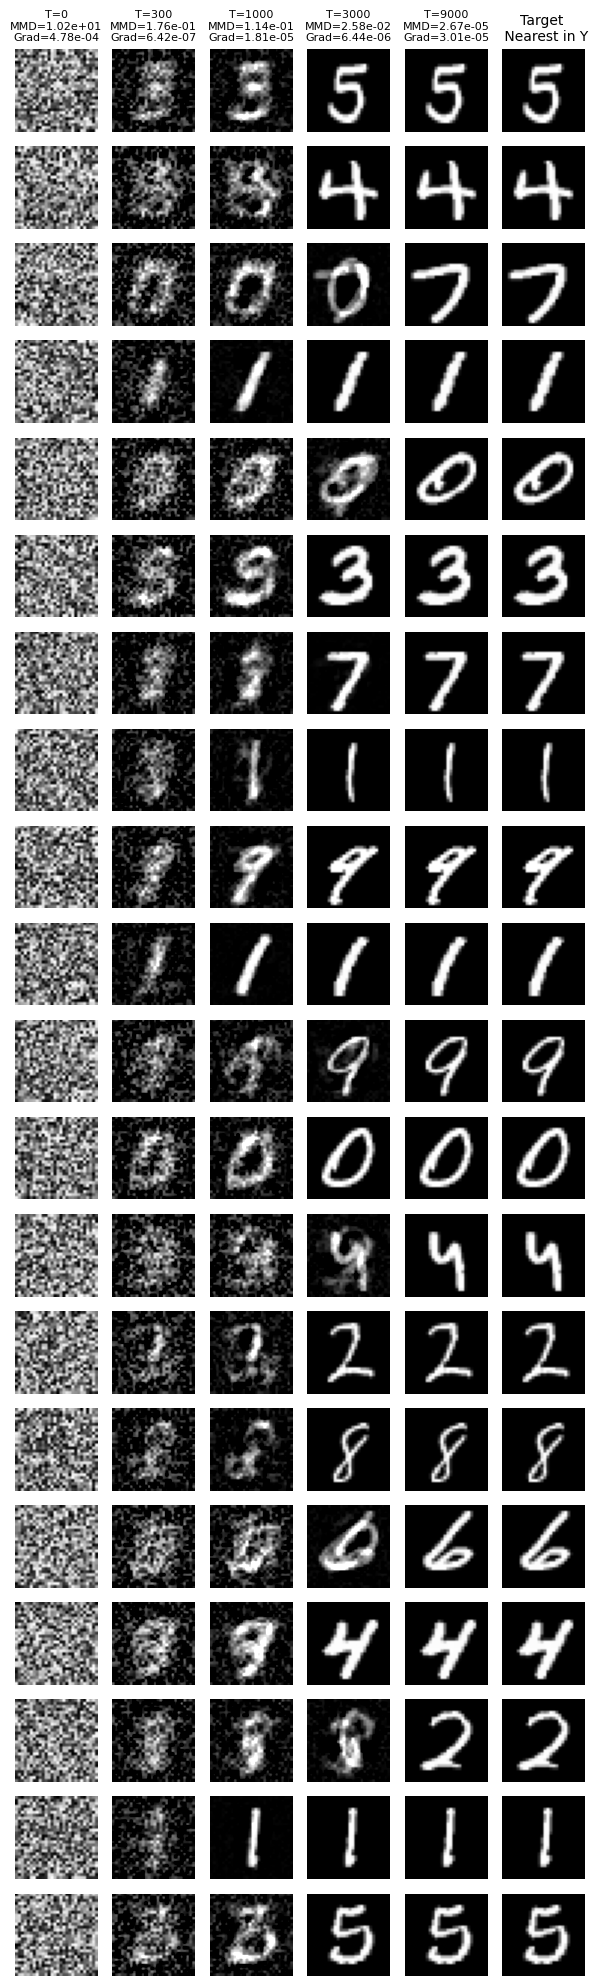

In [193]:
#iters = [0,1000,2000,5000,10000,15000,20000,79900]  
iters = [0,300,1000,3000,9000]
n_rows = 20
n_cols = len(iters) + 1

fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols, n_rows))




for i in range(n_rows):
    for j, it in enumerate(iters):
        img = x_evolv[it][i]
        img = img.reshape((28,28))
        axs[i, j].imshow(img.cpu(), cmap='gray', vmin=0, vmax=1)
        axs[i, j].axis('off')

    x_final = x_evolv[-1][i]

    for _ in range(64):
        dists = torch.norm(Y - x_final, dim=1)
        j = torch.argmin(dists)
        true_target = Y[j]

    # Dernière colonne : vraie image MNIST
    real_img = true_target.reshape((28,28))  
    axs[i, -1].imshow(real_img.cpu(), cmap='gray', vmin=0, vmax=1)
    axs[i, -1].axis('off')


for j, it in enumerate(iters):
    mmd = mmd_evolv[it]
    grad = grad_norm_evolv[it]
    axs[0, j].set_title(f"T={it}\nMMD={mmd:.2e}\nGrad={grad:.2e}", fontsize=8)


axs[0, -1].set_title("Target \n Nearest in Y", fontsize=10)

#espacement
plt.subplots_adjust(wspace=0.3, hspace=0.1)
plt.tight_layout()
plt.show()

In [167]:
X = x0

In [158]:
x0.shape

torch.Size([64, 784])

In [164]:
torch.mean(x0[:2],dim=0).unsqueeze(0).shape

torch.Size([1, 784])

In [198]:
X[0] = torch.mean(x0[:2],dim=0).unsqueeze(0)

In [180]:
X[0] = torch.rand(1,784)

In [184]:
X.shape

torch.Size([64, 784])

In [199]:
def sampling(x0,grad,n_steps,step_size,momentum=True,m=0.7):
    x = x0
    v = torch.zeros_like(x0)
    x_evolv = []
    N = x0.shape[0]
    for i in range(1,n_steps+1):
        # if i == 2:
        #     print(x.norm(),grad[i-1].norm(),m,v.norm(),step_size,N)
        if momentum:
            v = grad[i-1] + m * v
            x = x - step_size * N * v 
        else:
            x = x - step_size * N * grad[i-1]
        x_evolv.append(x)
        if i % 100 == 0 :
            print(torch.norm(torch.mean(grad[i-1],dim=0)))
    return x_evolv


#X = torch.rand((64,28**2))
grad = grad_evolv
step_size = 0.4
n_steps = 10_000
x_evolv = sampling(X,grad,n_steps,step_size)

tensor(8.4785e-07)
tensor(2.1979e-06)
tensor(4.0424e-06)
tensor(3.2380e-06)
tensor(1.5560e-06)
tensor(8.8867e-07)
tensor(6.0571e-07)
tensor(4.7195e-07)
tensor(3.9207e-07)
tensor(3.3811e-07)
tensor(3.3358e-07)
tensor(3.7537e-06)
tensor(5.3772e-06)
tensor(5.2262e-06)
tensor(5.7329e-06)
tensor(6.7046e-06)
tensor(9.3188e-06)
tensor(1.2151e-05)
tensor(9.0436e-06)
tensor(1.4541e-05)
tensor(1.1612e-05)
tensor(1.4959e-05)
tensor(1.7738e-05)
tensor(1.7586e-05)
tensor(1.7410e-05)
tensor(1.6627e-05)
tensor(1.1621e-05)
tensor(1.5046e-05)
tensor(1.0349e-05)
tensor(1.3066e-05)
tensor(1.4063e-05)
tensor(1.4733e-05)
tensor(1.5475e-05)
tensor(1.2012e-05)
tensor(1.2757e-05)
tensor(1.0060e-05)
tensor(6.6186e-06)
tensor(9.4197e-06)
tensor(8.1129e-06)
tensor(1.1948e-05)
tensor(7.1713e-06)
tensor(8.3163e-06)
tensor(5.5461e-06)
tensor(9.9536e-06)
tensor(1.3634e-05)
tensor(6.5981e-06)
tensor(4.7817e-06)
tensor(1.1463e-05)
tensor(6.0423e-06)
tensor(5.2605e-06)
tensor(9.1548e-06)
tensor(7.6346e-06)
tensor(7.654

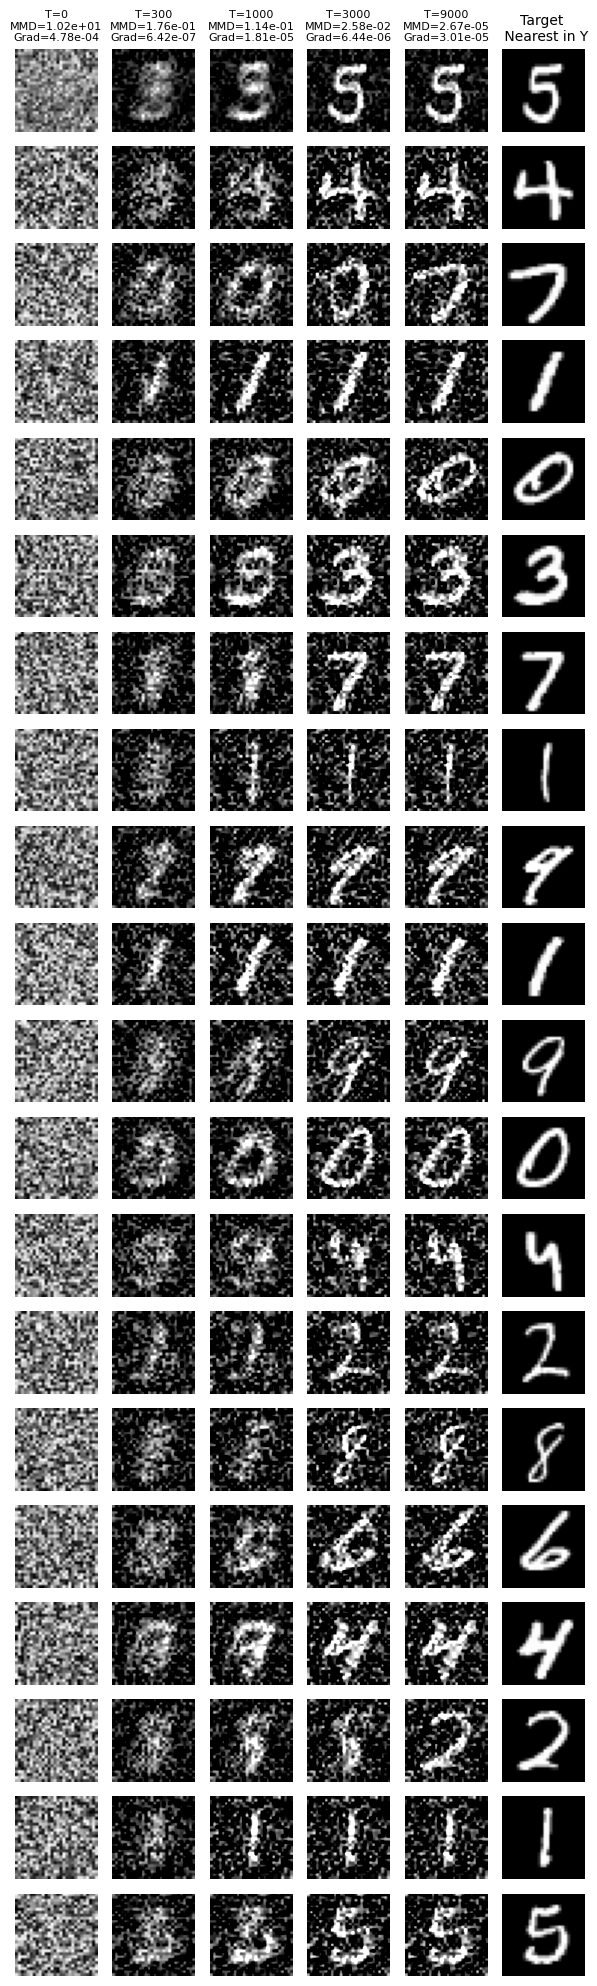

In [200]:
#iters = [0,1000,2000,5000,10000,15000,20000,79900]  
iters = [0,300,1000,3000,9000]
n_rows = 20
n_cols = len(iters) + 1

fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols, n_rows))




for i in range(n_rows):
    for j, it in enumerate(iters):
        img = x_evolv[it][i]
        img = img.reshape((28,28))
        axs[i, j].imshow(img.cpu(), cmap='gray', vmin=0, vmax=1)
        axs[i, j].axis('off')

    x_final = x_evolv[-1][i]

    for _ in range(64):
        dists = torch.norm(Y - x_final, dim=1)
        j = torch.argmin(dists)
        true_target = Y[j]

    # Dernière colonne : vraie image MNIST
    real_img = true_target.reshape((28,28))  
    axs[i, -1].imshow(real_img.cpu(), cmap='gray', vmin=0, vmax=1)
    axs[i, -1].axis('off')


for j, it in enumerate(iters):
    mmd = mmd_evolv[it]
    grad = grad_norm_evolv[it]
    axs[0, j].set_title(f"T={it}\nMMD={mmd:.2e}\nGrad={grad:.2e}", fontsize=8)


axs[0, -1].set_title("Target \n Nearest in Y", fontsize=10)

#espacement
plt.subplots_adjust(wspace=0.3, hspace=0.1)
plt.tight_layout()
plt.show()